In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely import geometry
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Validates rail service connections
## Needs PT LoS table

In [2]:
input_path = '../input_static/level_of_service_'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')

In [4]:
ln = stepmodel.read_json(model_path + 'de_pt_network_agg')
sm.zones = ln.zones

## Prepare the validation data
It had been fetched manually from the DB website beginning of January 2021, searching for trips two weeks ahead during early daytime.

In [5]:
val = pd.read_excel(input_path + 'validation_rail.xlsx', header=None, engine='xlrd')
val.columns = ['city', 'time', 'duration', 'ntransfers', 'services', 'cost_spar', 'cost_flex']

In [6]:
# Get the names right
val['city'] = val['city'].replace({'Hauptbahnhof, Bonn': 'Bonn'}).str.split(' ')
val['city'] = [l[0].split('(')[0] for l in list(val['city'])]

In [7]:
# Get origin and destination
d = [val.iloc[i, 0] for i in range(1, len(val), 2)]
val = val.iloc[::2, :].rename(columns={'city': 'o'})
val['d'] = d

In [8]:
# Get the times right
val.drop('time', axis=1, inplace=True)
val['duration'] = val['duration'].astype(str).str.split(':')
val['duration'] = [int(l[0]) + float(l[1])/60 for l in list(val['duration'])]

In [9]:
# Get the prices right
for col in ['cost_spar', 'cost_flex']:
    val[col] = [l[0] for l in list(val[col].str.split(','))]
    val[col] = val[col].astype(float)

In [10]:
val.head(4)

,o,duration,ntransfers,services,cost_spar,cost_flex,d
0,Hamburg,2.050000,0.0,ICE,29.0,75.0,Berlin
2,Hamburg,1.750000,0.0,ICE,29.0,75.0,Berlin
4,Köln,4.366667,0.0,ICE,29.0,114.0,Berlin
6,Köln,4.433333,0.0,ICE,39.0,114.0,Berlin


In [11]:
sm.zones['name'] = [l[0] for l in list(sm.zones['NUTS_NAME'].str.split(' '))]
sm.zones['name'] = [l[0] for l in list(sm.zones['name'].str.split(','))]
sm.zones['name'] = [l[0] for l in list(sm.zones['name'].str.split('('))]

In [12]:
# Length of zones with matching name
print(len(sm.zones.sort_values('urbanisation').loc[sm.zones['name'].isin(set(list(val[['o', 'd']].stack())))].drop_duplicates('name')))
print(len(set(list(val[['o', 'd']].stack()))))

27
34


In [13]:
# Generate a dictionary
nuts_dict = sm.zones.sort_values('urbanisation').loc[
    sm.zones['name'].isin(set(list(val[['o', 'd']].stack())))
].drop_duplicates('name').set_index('name')['NUTS_ID'].to_dict()

In [14]:
# Add missing zone IDs
missing = list(set(list(val[['o', 'd']].stack())) - set(nuts_dict.keys()))
missing.sort()
missing

['Hannover',
 'Kassel-Wilhelmshöhe',
 'Kelkheim',
 'Rheine',
 'Siegen',
 'Stralsund',
 'Zimmersrode']

In [16]:
missing_ids = ['DE929', 'DE731', 'DE71A', 'DEA37', 'DEA5A', 'DE80L', 'DE735']
nuts_dict.update({missing[i]: missing_ids[i] for i in range(len(missing))})

In [17]:
# Map names to IDs
val['o_nuts'] = val['o'].map(nuts_dict)
val['d_nuts'] = val['d'].map(nuts_dict)

In [18]:
# Get the distance as the crow flies
try:
    centroids = sm.zones.centroid
except AttributeError:
    sm.zones = gpd.GeoDataFrame(sm.zones)
    centroids = sm.zones.centroid
val['distance'] = [geodesic(centroids.loc[row['o_nuts']].coords,
                            centroids.loc[row['d_nuts']].coords).km
                   for _, row in val.iterrows()]

In [19]:
# Merge
val = val.merge(sm.pt_los[
    ['origin', 'destination', 'length', 'time', 'price', 'ntransfers', 'link_path', 'route_type', 'route_types', 'in_vehicle_time']
].loc[sm.pt_los['route_type'].str.startswith('rail')],
                how='left', left_on=['o_nuts', 'd_nuts'], right_on=['origin', 'destination'])
val.head()

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time
0,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,391.954332,DE600,DE300,389050,6485,70.650314,0,"[r_l_6457, r_l_6458]",rail_long,[rail_long],3300
1,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,391.954332,DE600,DE300,389050,6485,70.650314,0,"[r_l_9660, r_l_9661]",rail_long,[rail_long],3300
2,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,391.954332,DE600,DE300,402085,10409,127.208991,1,"[r_s_59130, r_s_59133, r_s_59136, r_s_146005, ...",rail_short,[rail_short],5220
3,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,391.954332,DE600,DE300,402085,10409,127.208991,1,"[r_s_59130, r_s_59133, r_s_59136, r_s_31249, r...",rail_short,[rail_short],5220
4,Hamburg,1.75,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,391.954332,DE600,DE300,389050,6485,70.650314,0,"[r_l_6457, r_l_6458]",rail_long,[rail_long],3300


In [20]:
# All connections should exist in the model
val.loc[val['link_path'].isna()]

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time


In [21]:
lines = [geometry.LineString([ln.links.loc[i, 'geometry'].coords[0] for i in l]
                             + [ln.links.loc[l[-1], 'geometry'].coords[-1]])
         for l in list(val.loc[val['link_path'].notna(), 'link_path'])]
gdf = gpd.GeoDataFrame(data={'ind': range(len(lines))}, geometry=lines)
cmap = cm.get_cmap('gist_rainbow')

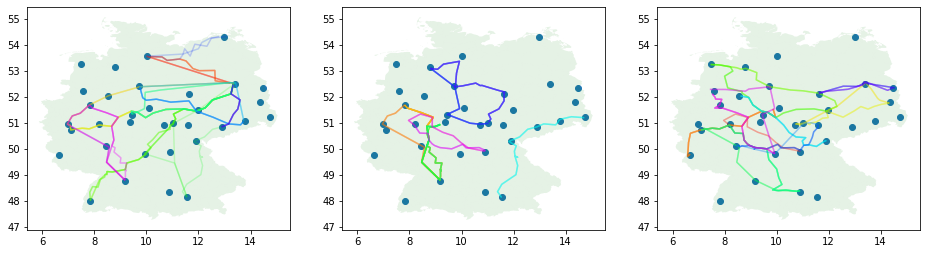

In [22]:
nplots = 3
cut = int(len(gdf)/nplots)
fix, axes = plt.subplots(nrows=1, ncols=nplots, figsize=(16,16))
for i in range(nplots):
    gdf.iloc[i*cut:(i+1)*cut].plot(cmap=cmap, alpha=.2, ax=sm.zones.plot(
        color='g', alpha=.1, ax=centroids.loc[set(val[['o_nuts', 'd_nuts']].stack())].plot(ax=axes[i])))

In [23]:
gdf.to_file(output_path + 'validation_rail.geojson', driver='GeoJSON')

In [24]:
def get_trend(x, y, label):
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker=' ', label=label)
    plt.scatter(x, y, marker='o', alpha=.2)
    print('{}: y={}*x+{}'.format(label, np.round(z[0], 2), np.round(z[1], 2)))

## Distance
Comparing as-the-crow-flies air distance and length of the model paths

In [25]:
# Convert to km
val['length'] = val['length'] / 1000

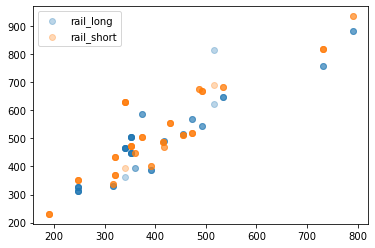

In [26]:
# X-axis is the direct distance between centroids
# Y-axis is the length of the corresponding route
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['length'],
                marker='o', alpha=.3, label=t)
plt.legend()

## Time
The PT graph should hold reasonable connections for the rail mode. Coach services are uncritical because they were not aggregated and persist as they come from GTFS feeds. Rail connections on the other hand relie on long- and short-distance trips which are algorithmically connected and aggregated.

In [27]:
# Convert to hours
val['time'] = val['time'] / 3600
val['in_vehicle_time'] = val['in_vehicle_time'] / 3600

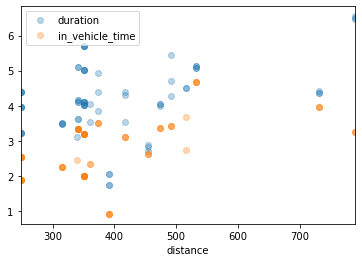

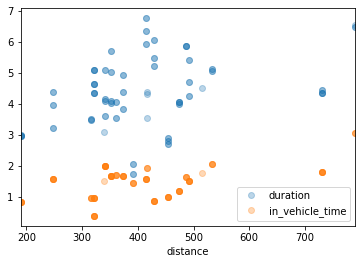

In [28]:
for t in ['rail_long', 'rail_short']:
    val.loc[val['route_type']==t][['duration', 'in_vehicle_time', 'distance']
                                 ].set_index('distance').plot(linestyle=' ', marker='o', alpha=.3)

rail_long: y=0.46*x+0.9
rail_short: y=0.13*x+0.86


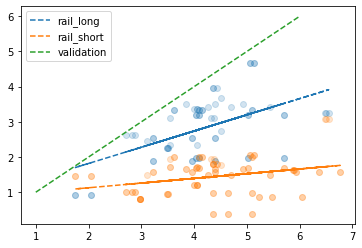

In [29]:
# In-vehicle time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['in_vehicle_time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

rail_long: y=0.65*x+1.18
rail_short: y=0.49*x+1.29


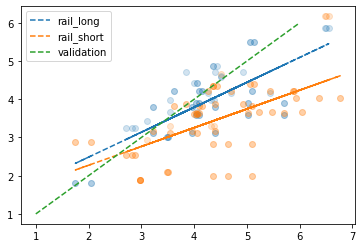

In [30]:
# Now for whole-path time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

When comparing in-vehicle travel times, both rail service are faster. This is due to the fact that model routes don't stick to one trip but are allowed to change between trains at every station if the other connection yields shorter time to the destination. Given the penalties for transfers (waiting time through link headway). For the whole path time, correlations look good

## Prices
In long-distance rail transport, there are "Sparpreise" which divert from regular distance-based price generation

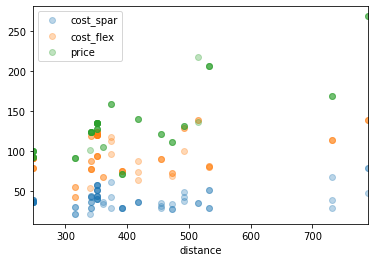

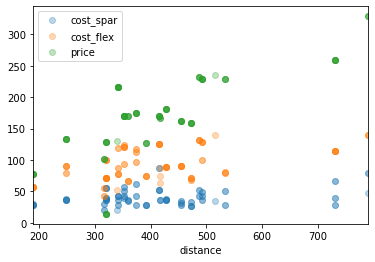

In [31]:
for t in ['rail_long', 'rail_short']:
    val.loc[val['route_type']==t][['cost_spar', 'cost_flex', 'price', 'distance']
                                 ].set_index('distance').plot(linestyle=' ', marker='o', alpha=.3)

price_los: y=0.27*x+5.55
cost_spar: y=0.03*x+27.04
cost_flex: y=0.07*x+66.46
price_los: y=0.33*x+7.01
cost_spar: y=0.03*x+27.65
cost_flex: y=0.1*x+52.31


Text(0.5, 1.0, 'Long- and short-distance prices in dependence of distance')

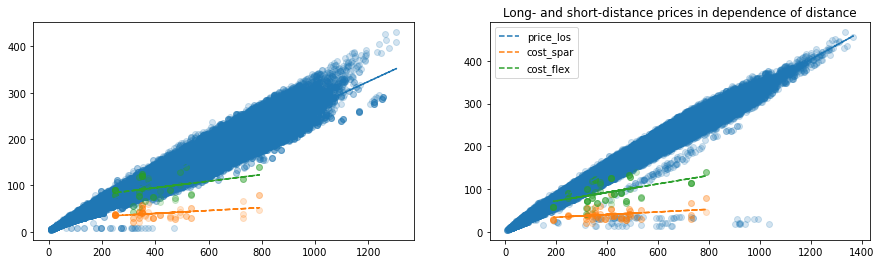

In [32]:
# Distance-dependency
fig = plt.figure(figsize=(15,4))
modes = ['rail_long', 'rail_short']
for i in range(len(modes)):
    plt.subplot(1,2,i+1)
    table = sm.pt_los.loc[sm.pt_los['route_type']==modes[i]].groupby(
        ['origin', 'destination']).first()
    x = table['length'] / 1000
    y = table['price']
    get_trend(x,y,'price_los')
    x = np.array(val.loc[val['route_type']==modes[i]]['distance'])
    for c in ['cost_spar', 'cost_flex']:
        y = np.array(val.loc[val['route_type']==modes[i]][c])
        get_trend(x,y,c)
plt.legend()
plt.title('Long- and short-distance prices in dependence of distance')

price_los: y=34.96*x+-14.45
cost_spar: y=5.89*x+16.55
cost_flex: y=11.55*x+49.79
price_los: y=56.0*x+-32.55
cost_spar: y=6.91*x+16.5
cost_flex: y=19.96*x+24.09


Text(0.5, 1.0, 'Long- and short-distance prices in dependence of duration')

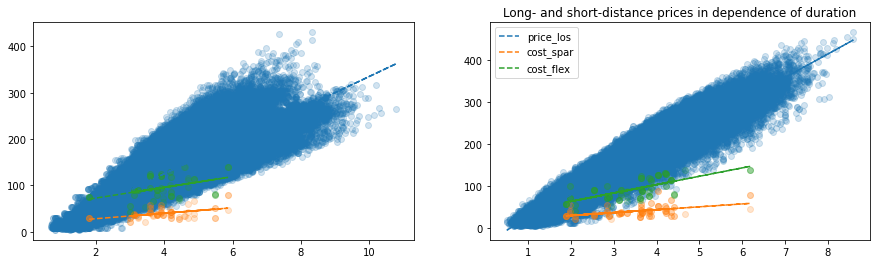

In [33]:
# Duration-dependency
fig = plt.figure(figsize=(15,4))
modes = ['rail_long', 'rail_short']
for i in range(len(modes)):
    plt.subplot(1,2,i+1)
    table = sm.pt_los.loc[sm.pt_los['route_type']==modes[i]].groupby(
        ['origin', 'destination']).first()
    x = table['time'] / 3600
    y = table['price']
    get_trend(x,y,'price_los')
    x = np.array(val.loc[val['route_type']==modes[i]]['time'])
    for c in ['cost_spar', 'cost_flex']:
        y = np.array(val.loc[val['route_type']==modes[i]][c])
        get_trend(x,y,c)
plt.legend()
plt.title('Long- and short-distance prices in dependence of duration')

Obviously, the price structure must be adjusted. This is due to the assumption that all rail link cost depend on link distance as stated in the DB price file. However, this is only true for short-distance fares whereas long-distance connections require a new price function for links. **Assumptions long-distance rail prices**:

- Rail transport is purely path-distance-dependent
- Price dependency is linear
- The model's price comes close to the Flexpreis with some variance
- There is a price cap of 139 EUR

In [34]:
ln.links.loc[ln.links['route_type']=='rail_long', 'price'] = \
    ln.links.loc[ln.links['route_type']=='rail_long', 'length'].apply(
        lambda x: 0.03 * x/1000)

In [35]:
# Sum up prices in LoS table based on link fares
price_dict = ln.links['price'].to_dict()
sm.pt_los['price_2'] = sm.pt_los['link_path'].apply(
    lambda l: sum([price_dict[link] for link in l]))
# Add static part to long-distance connections
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price_2'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_long',
                  'price_2'] + (27+66)/2
# Add price cap
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price_2'] = \
    np.minimum(139, sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price_2'])
# Add local transport fee as in prep31
sm.pt_los.loc[sm.pt_los['route_types'].apply(lambda t: 'bus' in t),
              'price_2'] = sm.pt_los['price_2'] + \
    sm.pt_los.loc[sm.pt_los['route_type']=='bus', 'price'].mean()

**Short-distance rail** services have the price structure stated in the DB document. However, most people who use it have some kind of abonement and don't buy single trip tickets. cal10 shows that for trips under 50km distance there is a 50% share of permanent abonements. Moreover, it doesn't make sense to choose short-distance rail services on long distances. Still, if so, people choose the "Quer-durchs-Land-Ticket" for 42€.

In [36]:
# Alter short-distance prices
mask = (sm.pt_los['route_type']=='rail_short') & (sm.pt_los['length']<50000)
sm.pt_los.loc[mask, 'price_2'] = sm.pt_los.loc[mask, 'price'] / 2
# Add price cap
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price_2'] = \
    np.minimum(42, sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price_2'])

price_los: y=0.07*x+43.22
cost_spar: y=0.03*x+27.04
cost_flex: y=0.07*x+66.46
price_los: y=0.01*x+38.74
cost_spar: y=0.03*x+27.65
cost_flex: y=0.1*x+52.31


Text(0.5, 1.0, 'Long- and short-distance prices in dependence of distance')

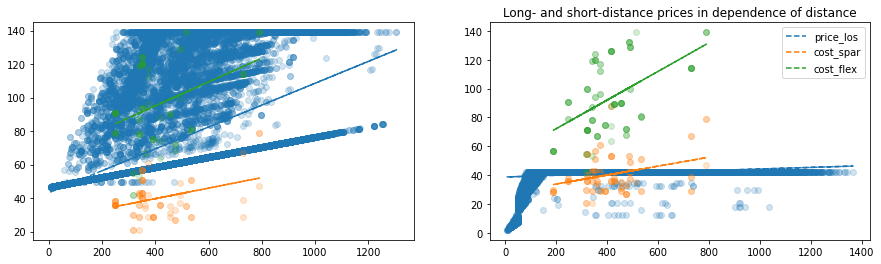

In [37]:
# Corrected
fig = plt.figure(figsize=(15,4))
modes = ['rail_long', 'rail_short']
for i in range(len(modes)):
    plt.subplot(1,2,i+1)
    table = sm.pt_los.loc[sm.pt_los['route_type']==modes[i]].groupby(
        ['origin', 'destination']).first()
    x = table['length'] / 1000
    y = table['price_2']
    get_trend(x,y,'price_los')
    x = np.array(val.loc[val['route_type']==modes[i]]['distance'])
    for c in ['cost_spar', 'cost_flex']:
        y = np.array(val.loc[val['route_type']==modes[i]][c])
        get_trend(x,y,c)
plt.legend()
plt.title('Long- and short-distance prices in dependence of distance')

In [38]:
sm.pt_los.loc[(sm.pt_los['route_type']=='rail_long') & (sm.pt_los['price_2']<20)]

,origin,destination,route_types,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_type,accessibility,price_2
index,,,,,,,,,,,,,,,


In [39]:
len(sm.pt_los.loc[(sm.pt_los['route_type']=='rail_short') & (sm.pt_los['price_2']<5)])

308

In [40]:
sm.pt_los = sm.pt_los.drop('price', axis=1).rename(columns={'price_2': 'price'})

In [41]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,length,route_type,accessibility,price
index,,,,,,,,,,,,,,
433263,DE93B,DE254,[rail_long],"[r_l_1541, r_l_1542, r_l_5176, r_l_5177, r_l_5...",2,1885,0,10320,2700,14905,555291,rail_long,0.0,63.15873


## Save

In [42]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:08<00:00,  4.08it/s]


In [43]:
# Save the merged validation table
writer = pd.ExcelWriter(output_path + 'validation_rail_merged.xlsx', engine='xlsxwriter')
val.to_excel(writer)
writer.save()